## Resources

- https://rtdew1.github.io/#research
- https://deliverypdf.ssrn.com/delivery.php?ID=437004004092116102112081007115085100113004071015039058088007022119000115065101121025101010116127126036124022103112072006028021016015022093033075007022030093123074027005089055101008125010121127088121118024120014080084103086015111116116068127029104027086&EXT=pdf&INDEX=TRUE
- https://rtdew1.github.io/gppm_replication_notebook.html
- https://github.com/rtdew1/rtdew1.github.io/blob/master/gppm.stan

## Prepare Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"


%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
seed: int = sum(map(ord, "clv_gp"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Read Data

In [23]:
data_df = pl.read_csv(
    "https://raw.githubusercontent.com/rtdew1/rtdew1.github.io/master/ls_sim.csv"
)
data_df = data_df.filter(pl.col("id") < 200)
data_df.head()

y,id,fs,t,r,l,pnum
i64,i64,i64,i64,i64,i64,i64
0,1,20,21,1,1,2
0,1,20,22,2,2,2
0,1,20,23,3,3,2
0,1,20,24,4,4,2
0,1,20,25,5,5,2


## EDA

In [24]:
data_df["id"].unique().shape[0]

199

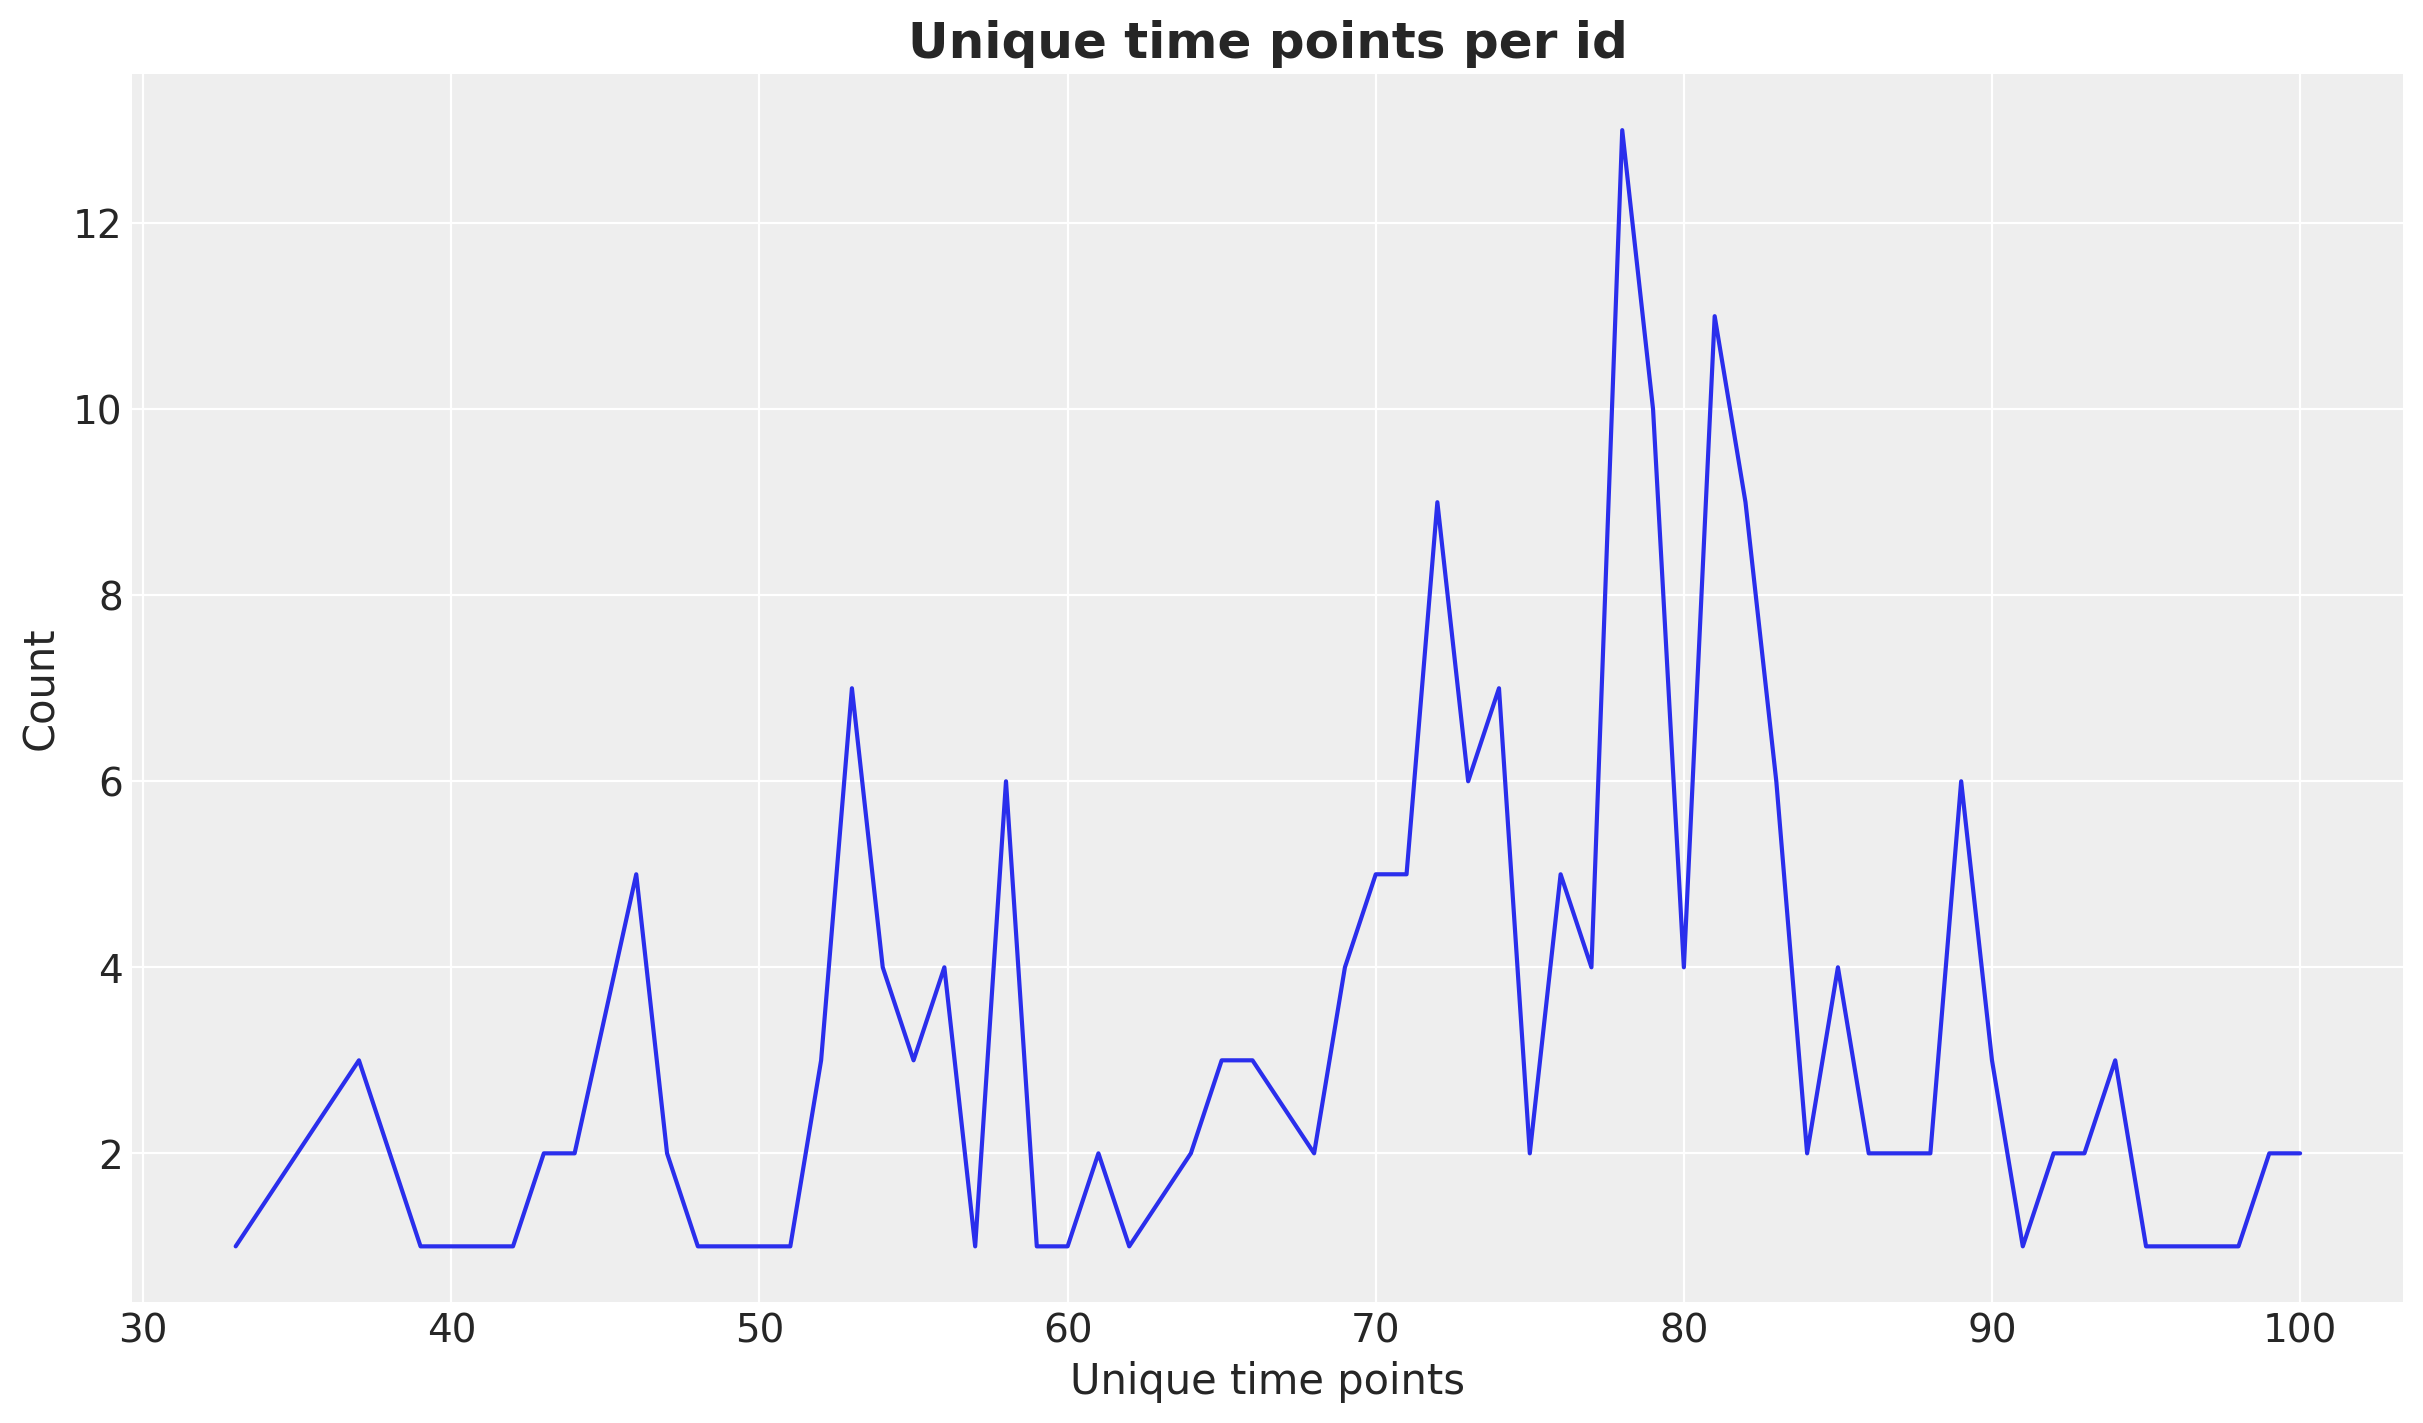

In [25]:
fig, ax = plt.subplots()
(
    data_df.group_by("id")
    .agg(pl.col("t").count().alias("t_unique"))
    .sort("t_unique")
    .group_by("t_unique")
    .agg(pl.col("id").count().alias("count"))
    .pipe(lambda df: sns.lineplot(data=df, x="t_unique", y="count", ax=ax))
)
ax.set(xlabel="Unique time points", ylabel="Count")
ax.set_title("Unique time points per id", fontsize=18, fontweight="bold");

In [26]:
(
    data_df.group_by("id")
    .agg(pl.col("t").max().alias("max_t"))
    .select(pl.col("max_t").unique().alias("max_t_unique"))
)

max_t_unique
i64
100


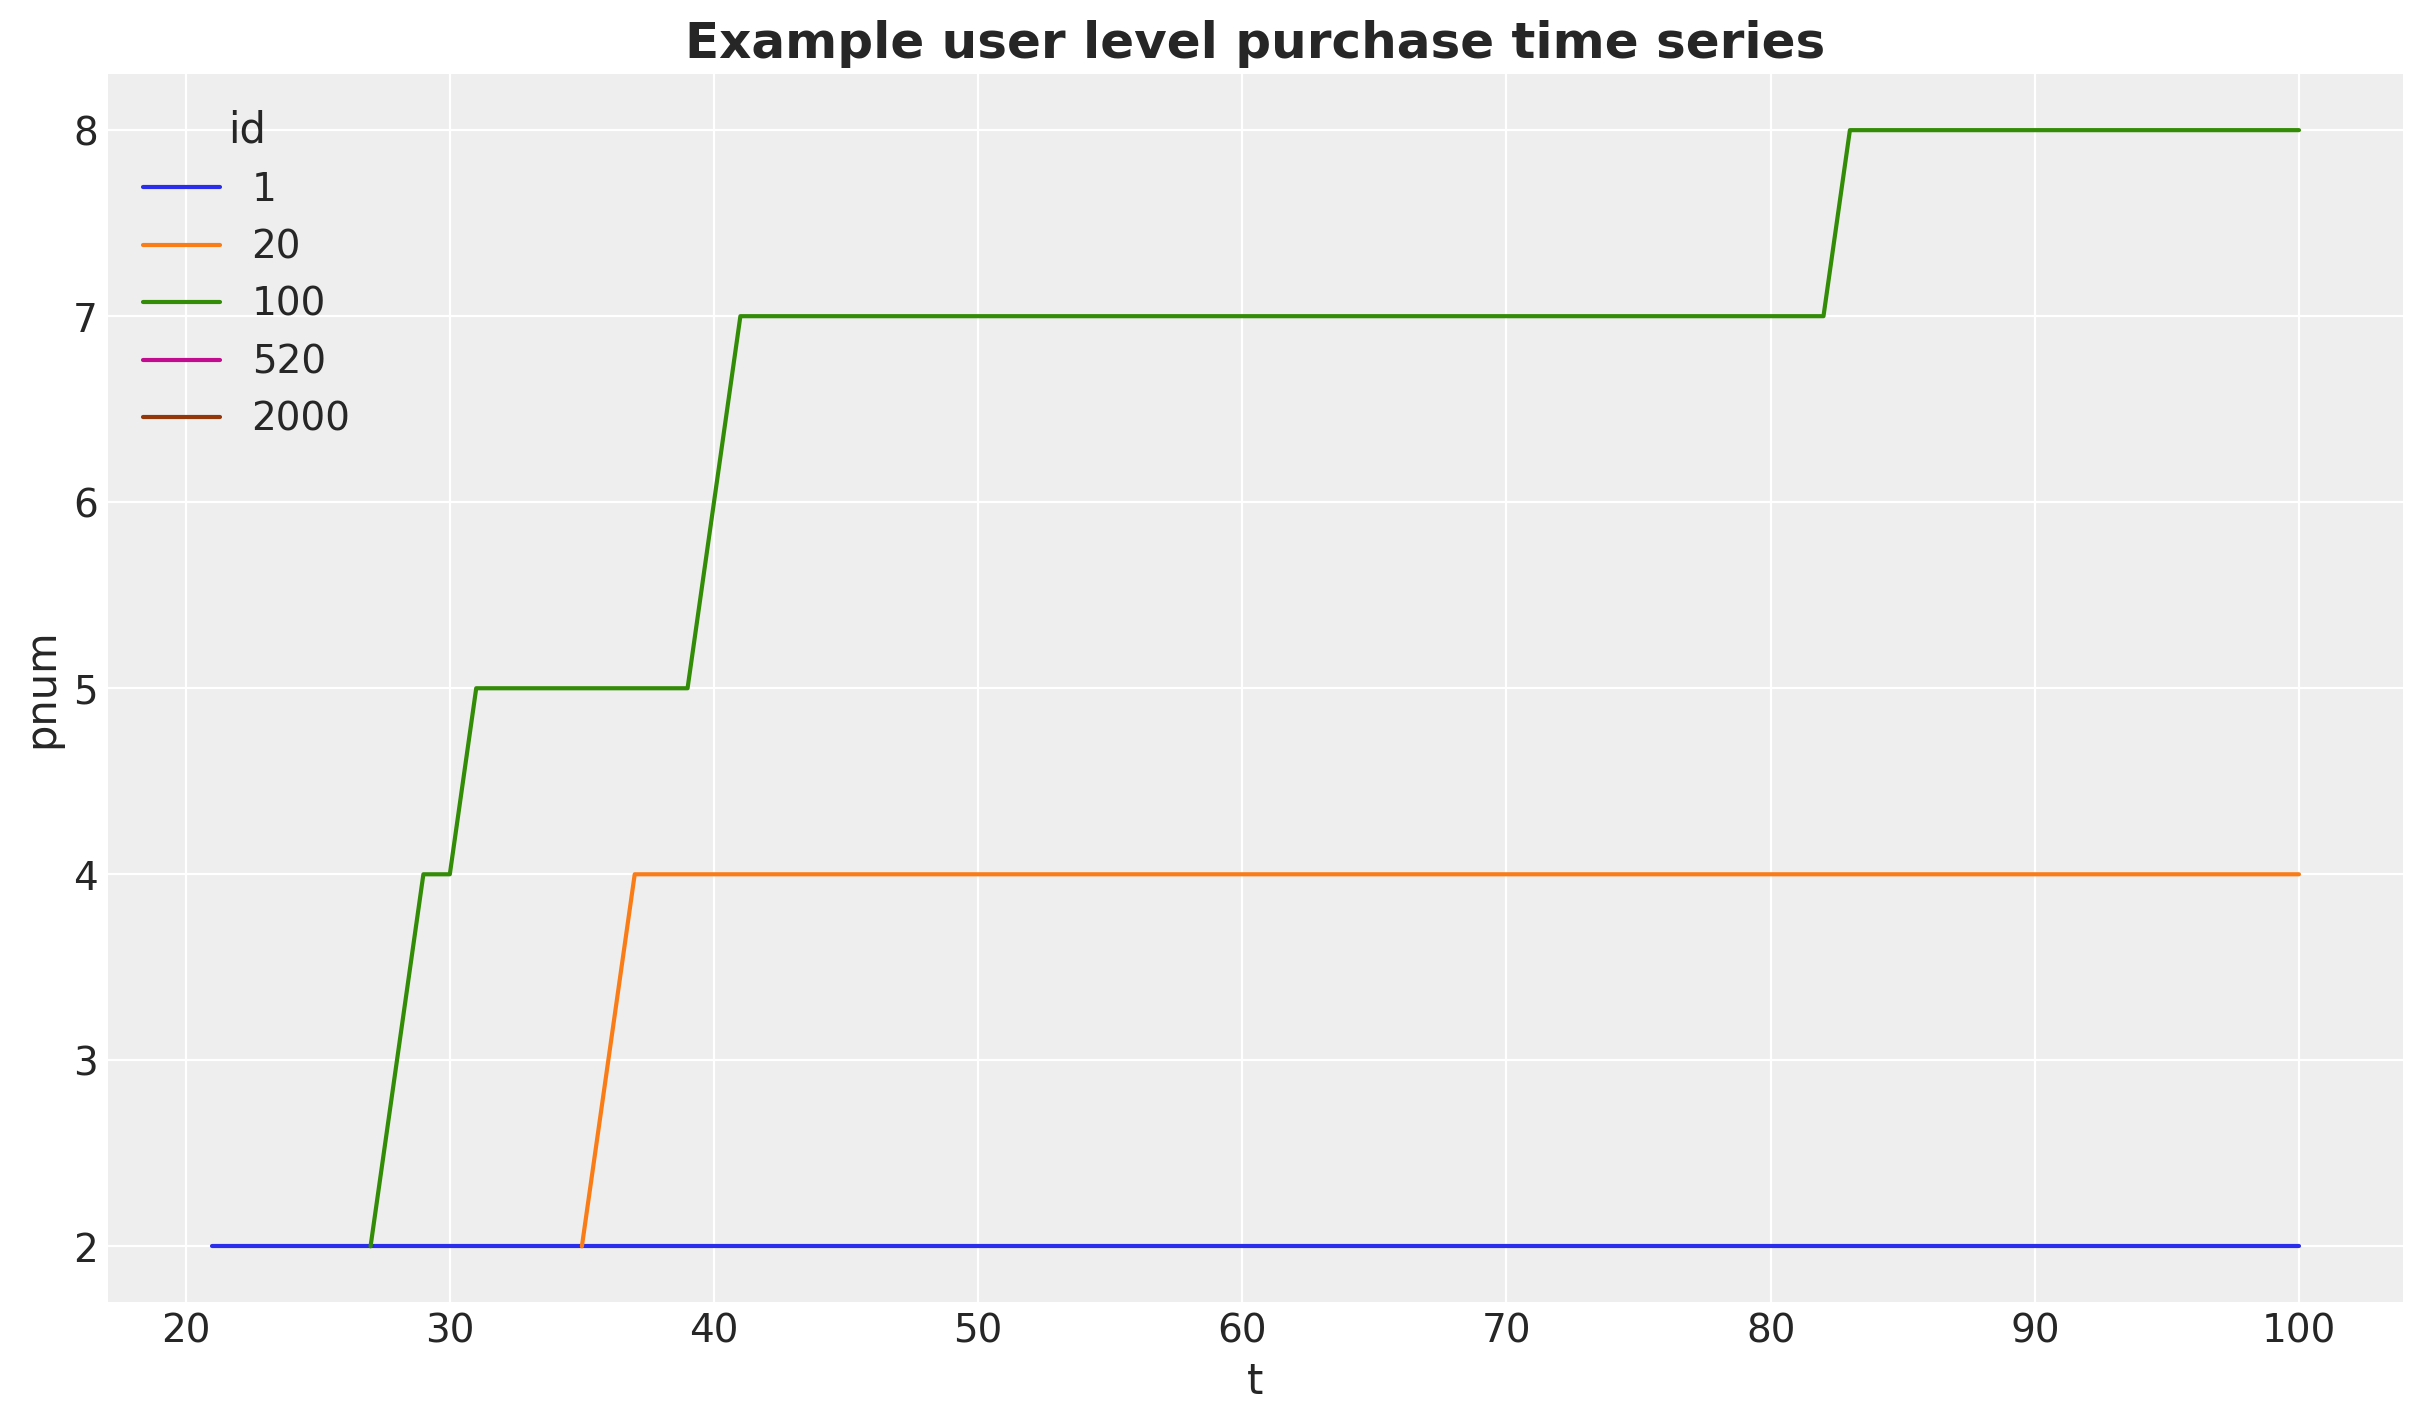

In [27]:
fig, ax = plt.subplots()
for i, idx in enumerate([1, 20, 100, 520, 2000]):
    sns.lineplot(
        data=data_df.filter(pl.col("id") == idx),
        x="t",
        y="pnum",
        color=f"C{i}",
        label=idx,
        ax=ax,
    )
ax.legend(title="id", title_fontsize=15, loc="upper left")
ax.set_title("Example user level purchase time series", fontsize=18, fontweight="bold");

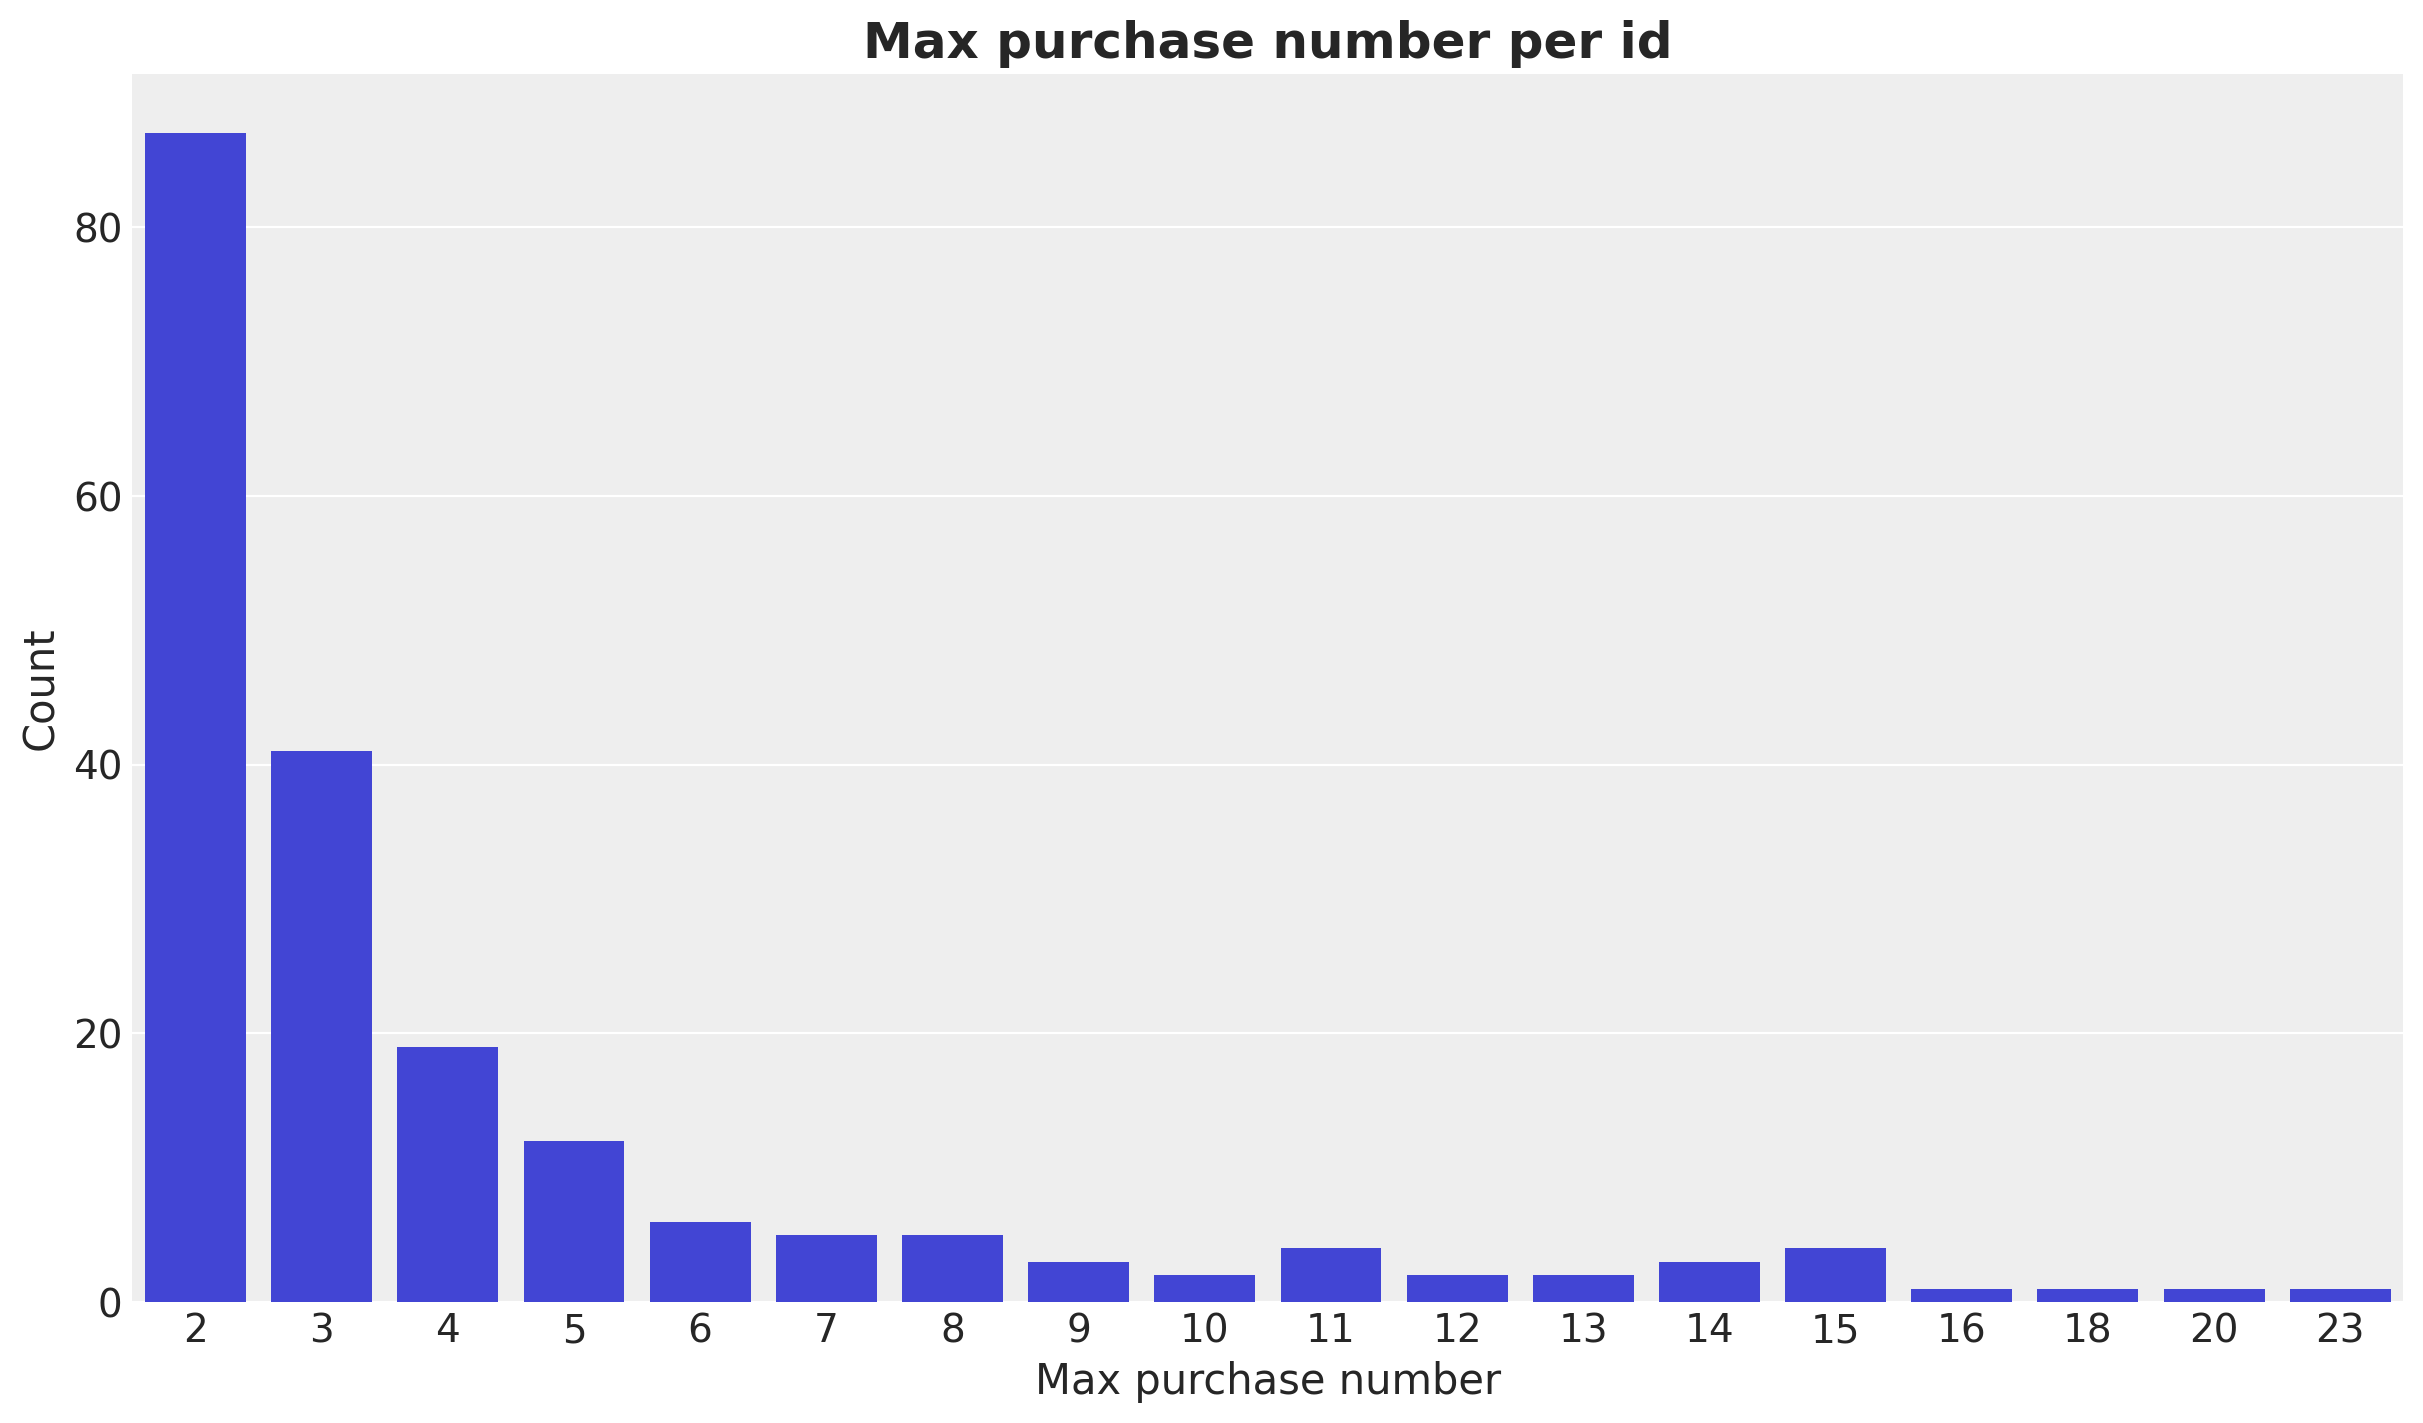

In [28]:
fig, ax = plt.subplots()
(
    data_df.group_by("id")
    .agg(pl.col("pnum").max().alias("max_pnum"))
    .group_by("max_pnum")
    .agg(pl.col("id").count().alias("count"))
    .sort("count")
    .pipe(lambda df: sns.barplot(data=df, x="max_pnum", y="count"))
)
ax.set(xlabel="Max purchase number", ylabel="Count")
ax.set_title("Max purchase number per id", fontsize=18, fontweight="bold");

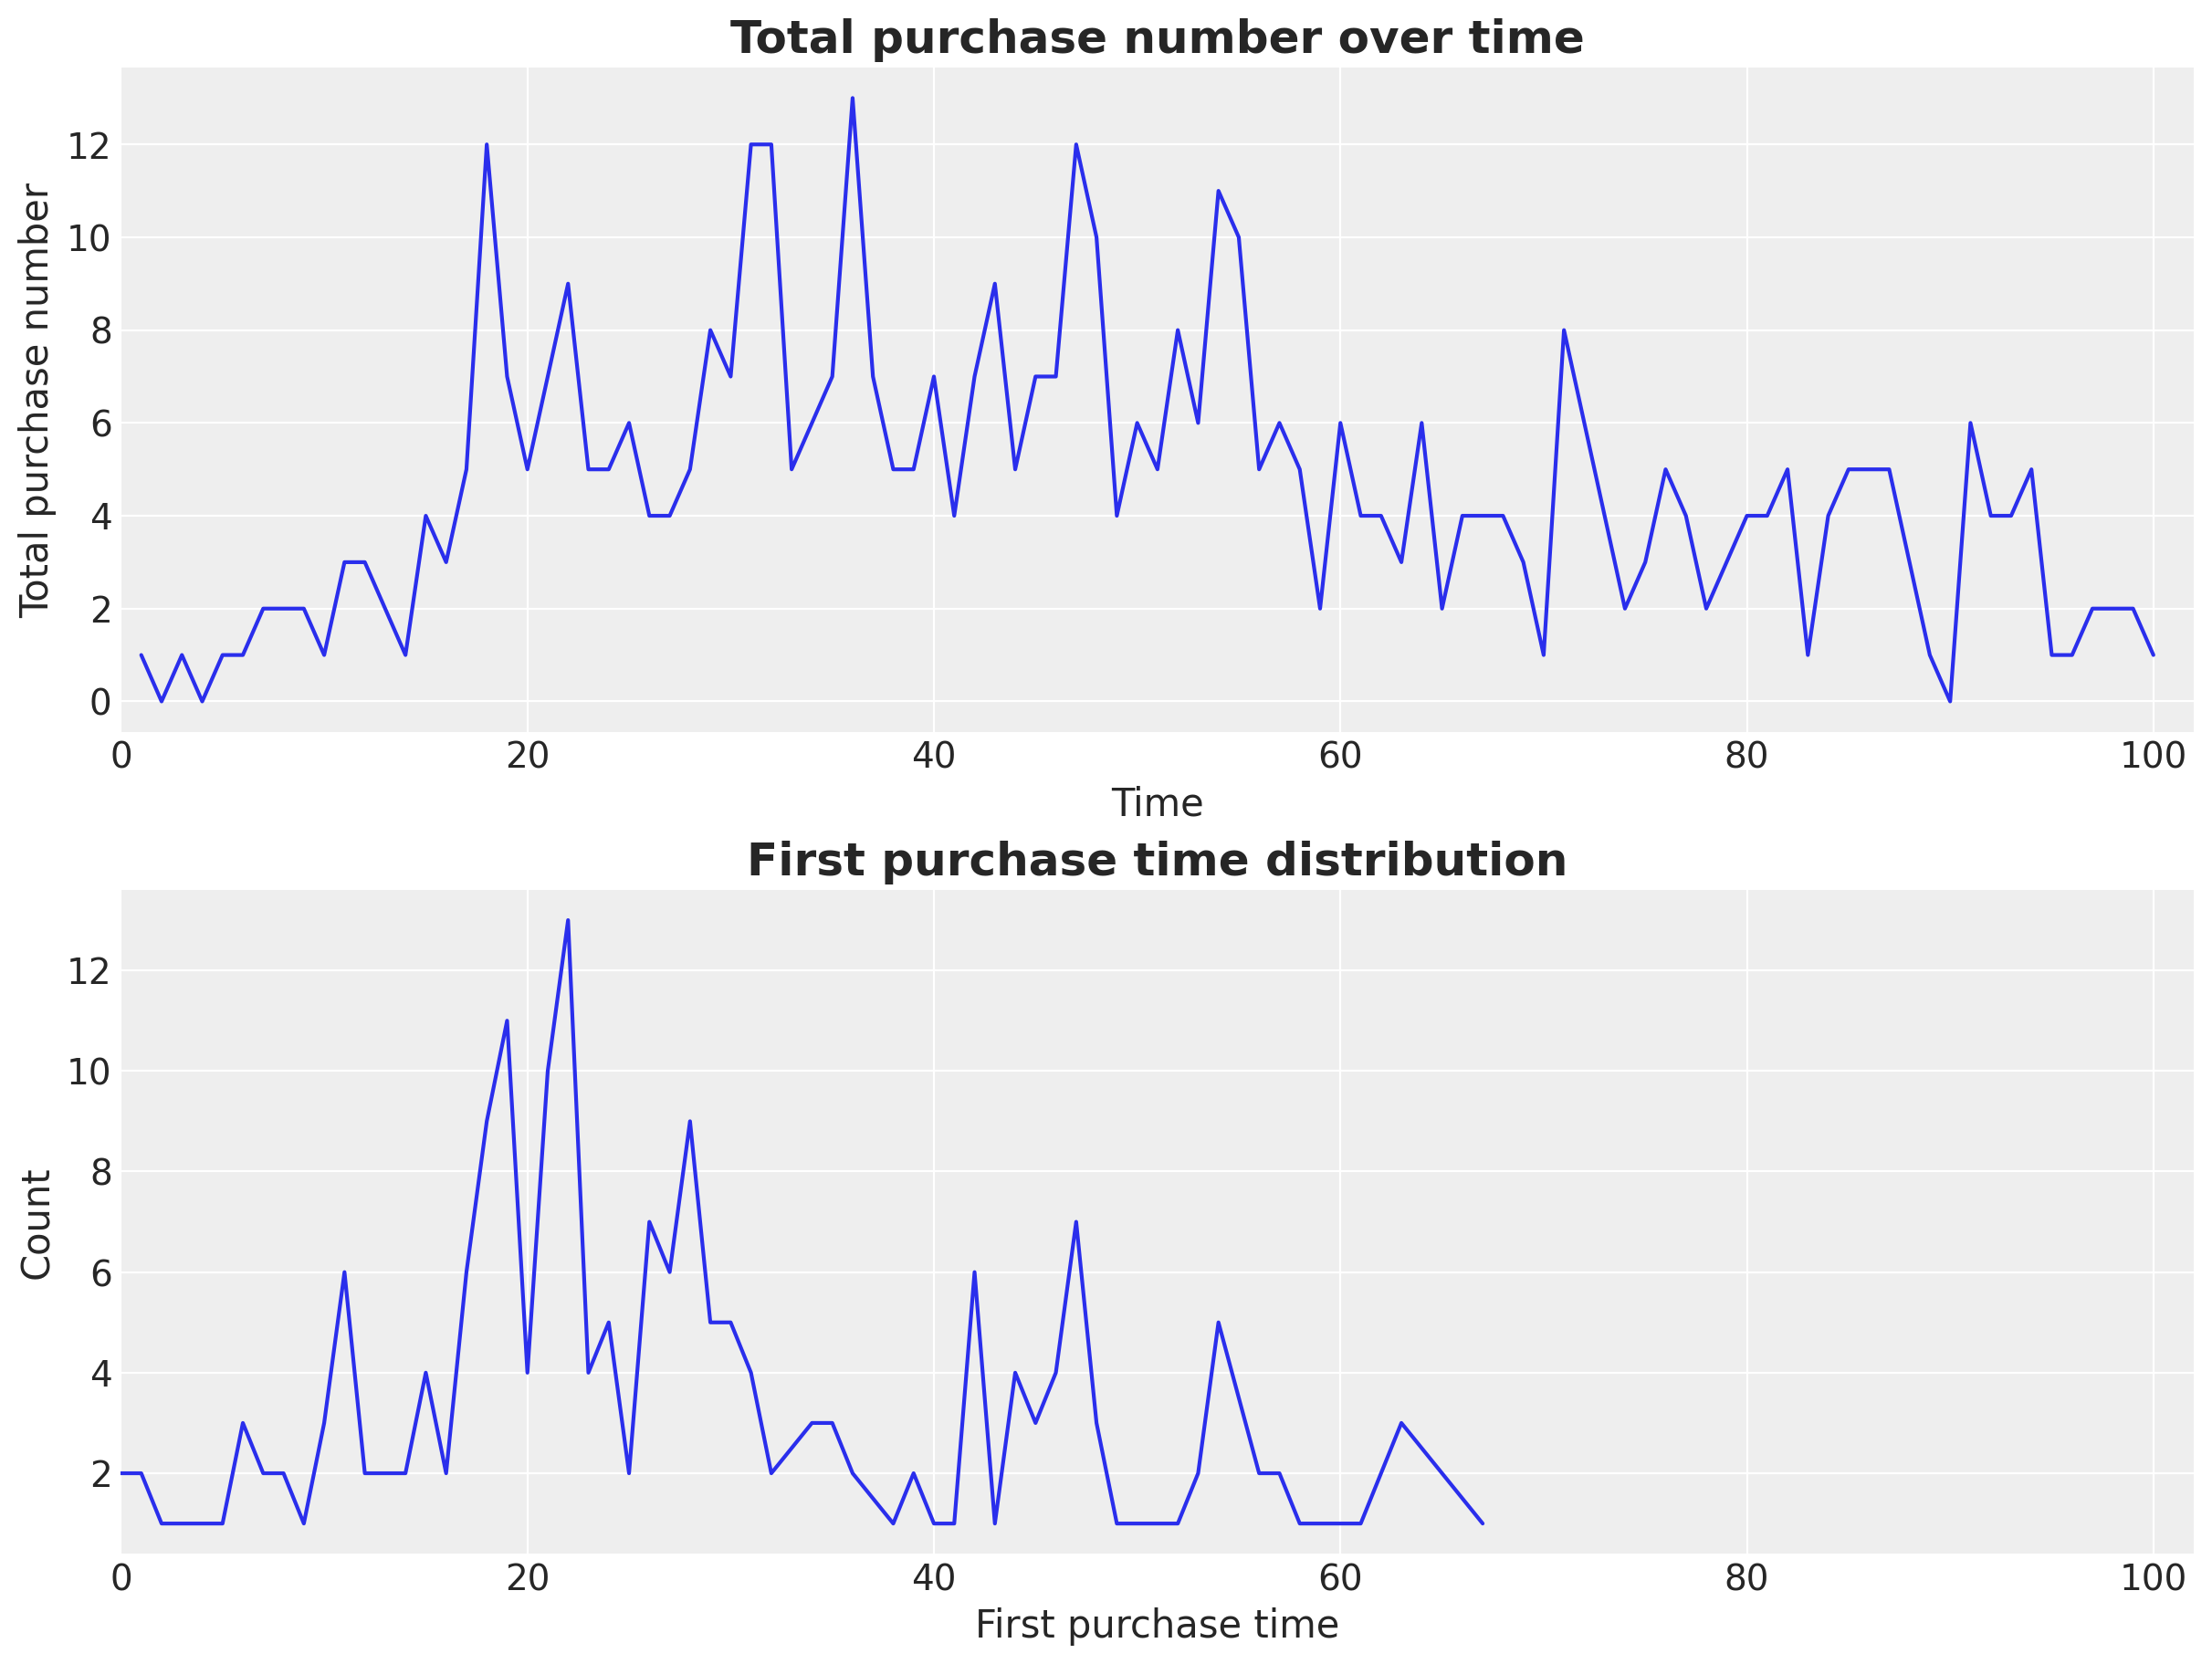

In [29]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 9), sharex=False, sharey=False, layout="constrained"
)

data_df.group_by("t").agg(pl.col("y").sum().alias("total_y")).pipe(
    lambda df: sns.lineplot(data=df, x="t", y="total_y", ax=ax[0])
)
ax[0].set(xlabel="Time", ylabel="Total purchase number", xlim=(0, 102))
ax[0].set_title("Total purchase number over time", fontsize=18, fontweight="bold")

data_df.select(pl.col("id"), pl.col("fs")).unique(subset=["id", "fs"]).group_by(
    "fs"
).len().pipe(lambda df: sns.lineplot(data=df, x="fs", y="len", ax=ax[1]))
ax[1].set(xlabel="First purchase time", ylabel="Count", xlim=(0, 102))
ax[1].set_title("First purchase time distribution", fontsize=18, fontweight="bold");

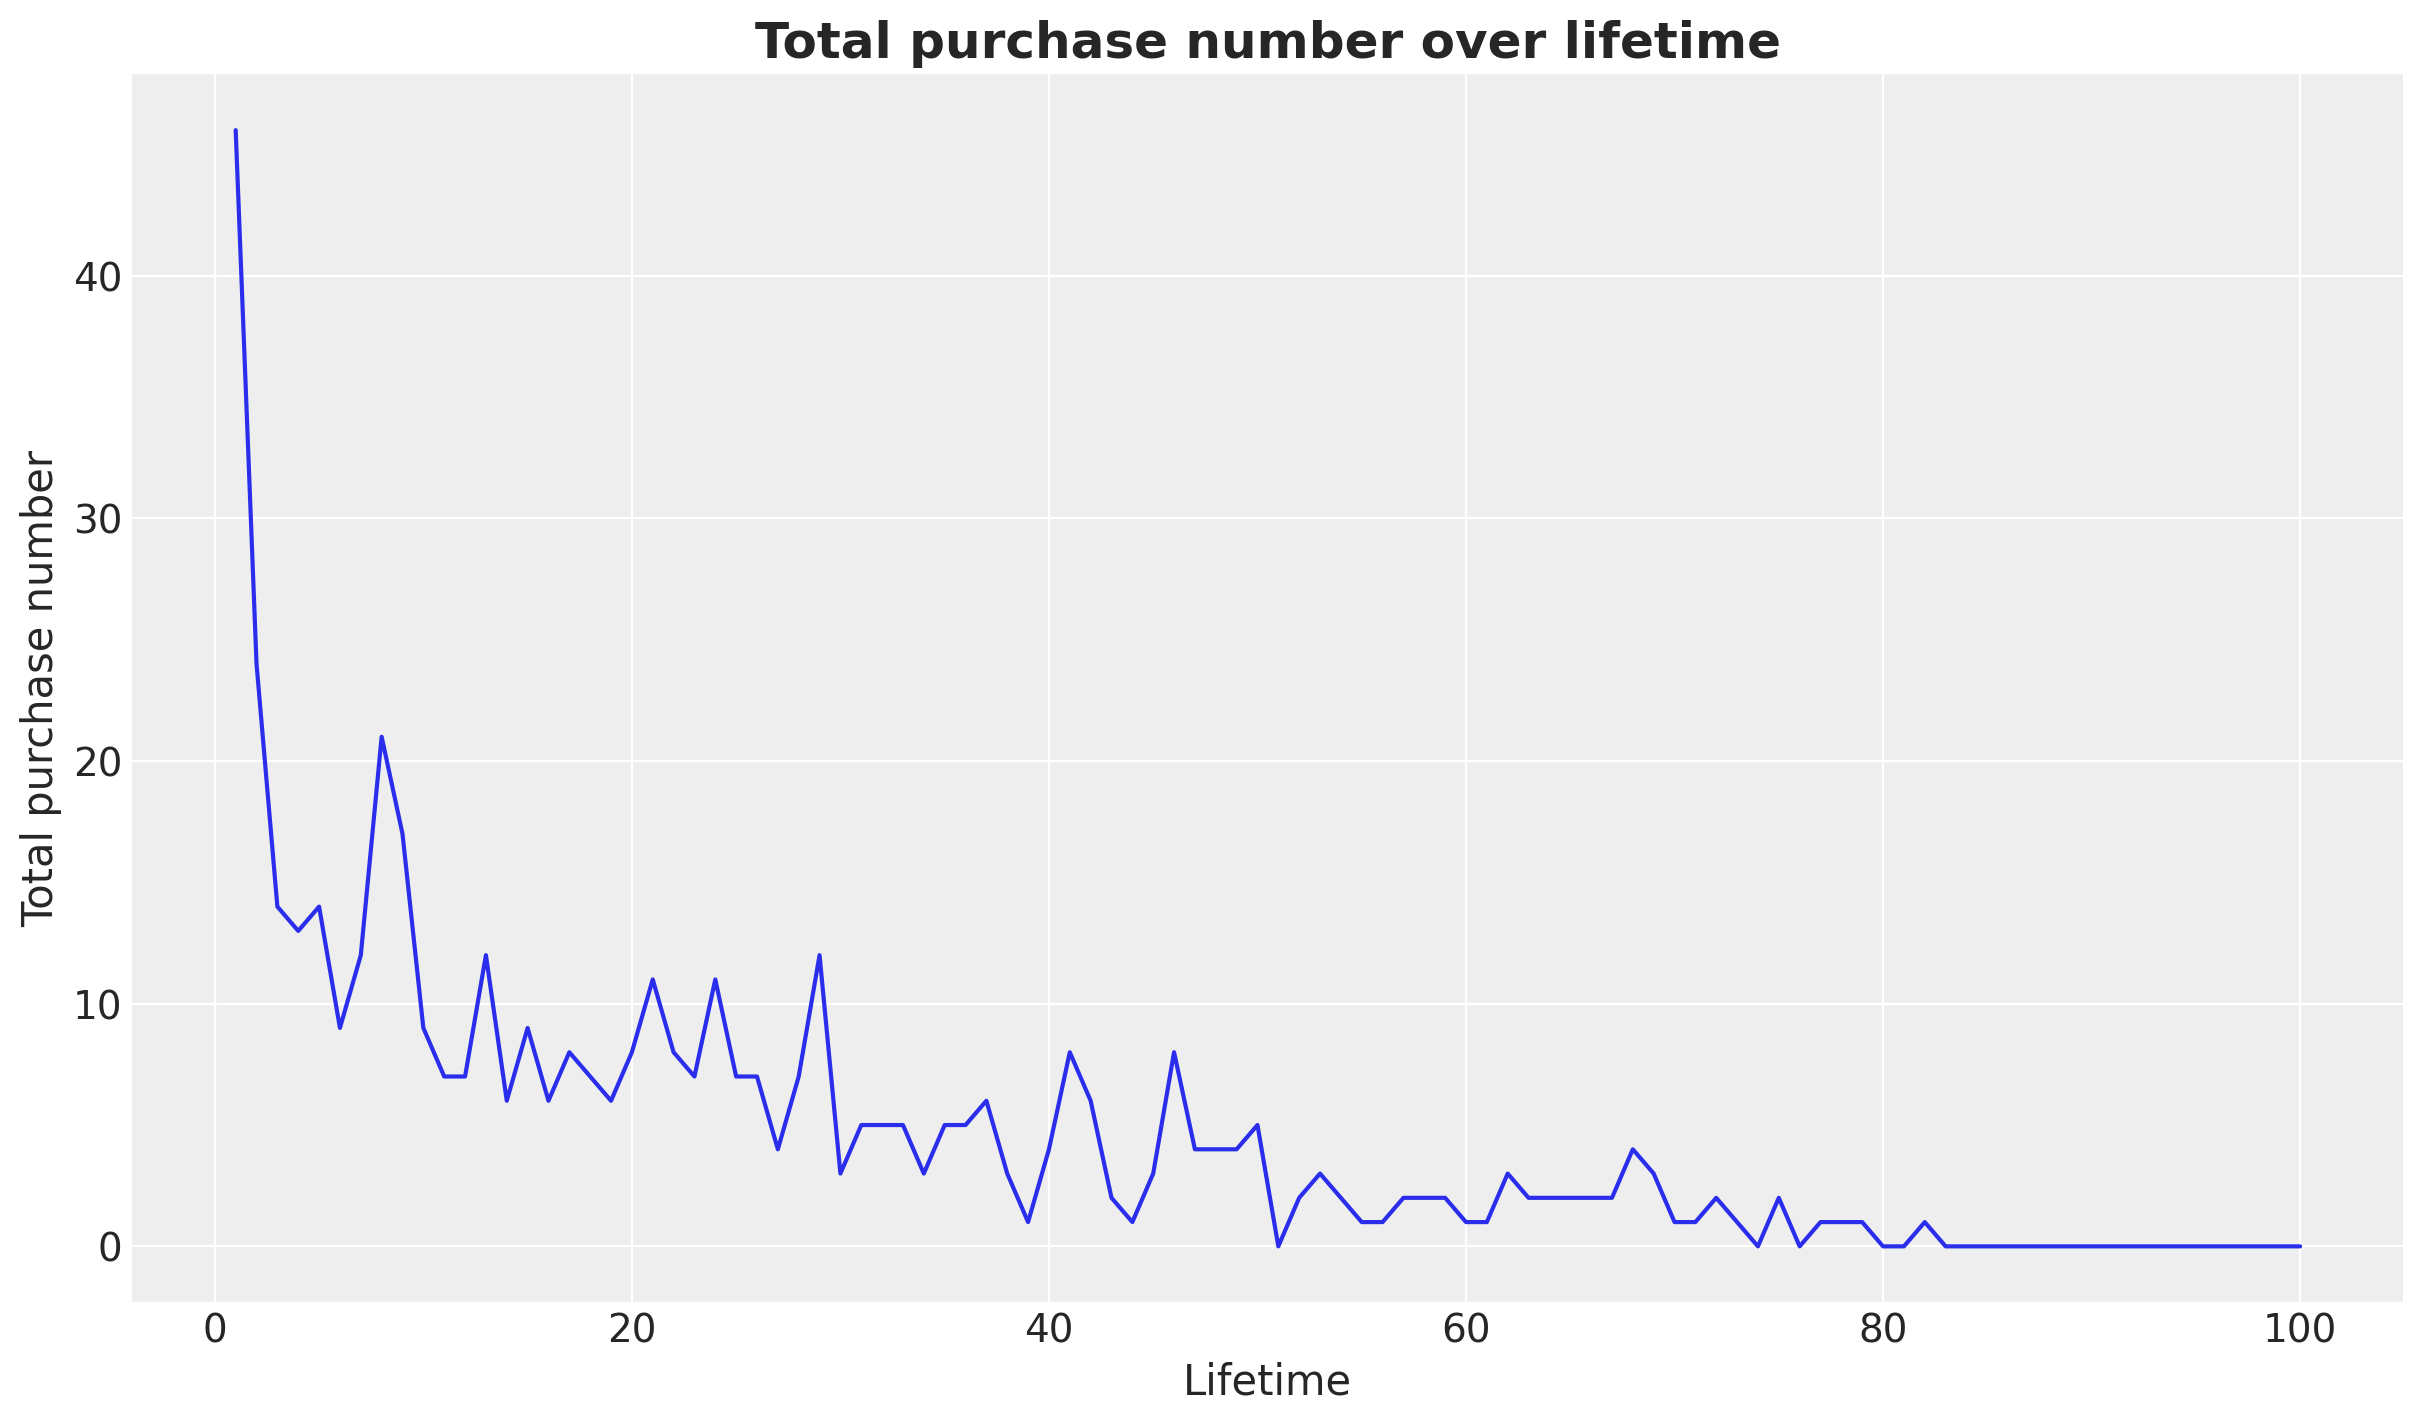

In [30]:
fig, ax = plt.subplots()
data_df.group_by("l").agg(pl.col("y").sum().alias("total_y")).pipe(
    lambda df: sns.lineplot(data=df, x="l", y="total_y", ax=ax)
)
ax.set(xlabel="Lifetime", ylabel="Total purchase number")
ax.set_title("Total purchase number over lifetime", fontsize=18, fontweight="bold");

## Train Test Split

In [31]:
data_df["fs"].max()

67

In [32]:
fs_threshold = data_df["fs"].max() + 1

data_df = data_df.with_columns(
    idx_id=pl.col("id").rank("dense") - 1,
    idx_t=pl.col("t").rank("dense") - 1,
)

train_df = data_df.filter(pl.col("t") <= fs_threshold)
test_df = data_df.filter(pl.col("t") > fs_threshold)

In [33]:
assert set(train_df["id"].unique()) == set(test_df["id"].unique())

In [34]:
# Train data
n_train = train_df.shape[0]
id_train = train_df["id"].unique().to_numpy()
idx_id_train = train_df["idx_id"].to_numpy()
t_train = train_df["t"].sort().unique().to_numpy()
idx_t_train = train_df["idx_t"].to_numpy()
rec_train = train_df["r"].to_numpy()
life_train = train_df["l"].to_numpy()
pnum_train = (train_df["pnum"] - train_df["pnum"].min() + 1).to_numpy()
y_train = train_df["y"].to_numpy()

# Test data
n_test = test_df.shape[0]
id_test = test_df["id"].to_numpy()
idx_id_test = test_df["idx_id"].to_numpy()
t_test = test_df["t"].sort().unique().to_numpy()
idx_t_test = test_df["idx_t"].to_numpy() - fs_threshold
rec_test = test_df["r"].to_numpy()
life_test = test_df["l"].to_numpy()
pnum_test = (test_df["pnum"] - train_df["pnum"].min() + 1).to_numpy()
y_test = test_df["y"].to_numpy()

In [35]:
assert t_train.min() == 1
assert t_test.min() == fs_threshold + 1
np.testing.assert_equal(t_train[idx_t_train], train_df["t"].to_numpy())
np.testing.assert_equal(t_test[idx_t_test], test_df["t"].to_numpy())

assert pnum_train.min() == 1
assert pnum_test.min() == 1

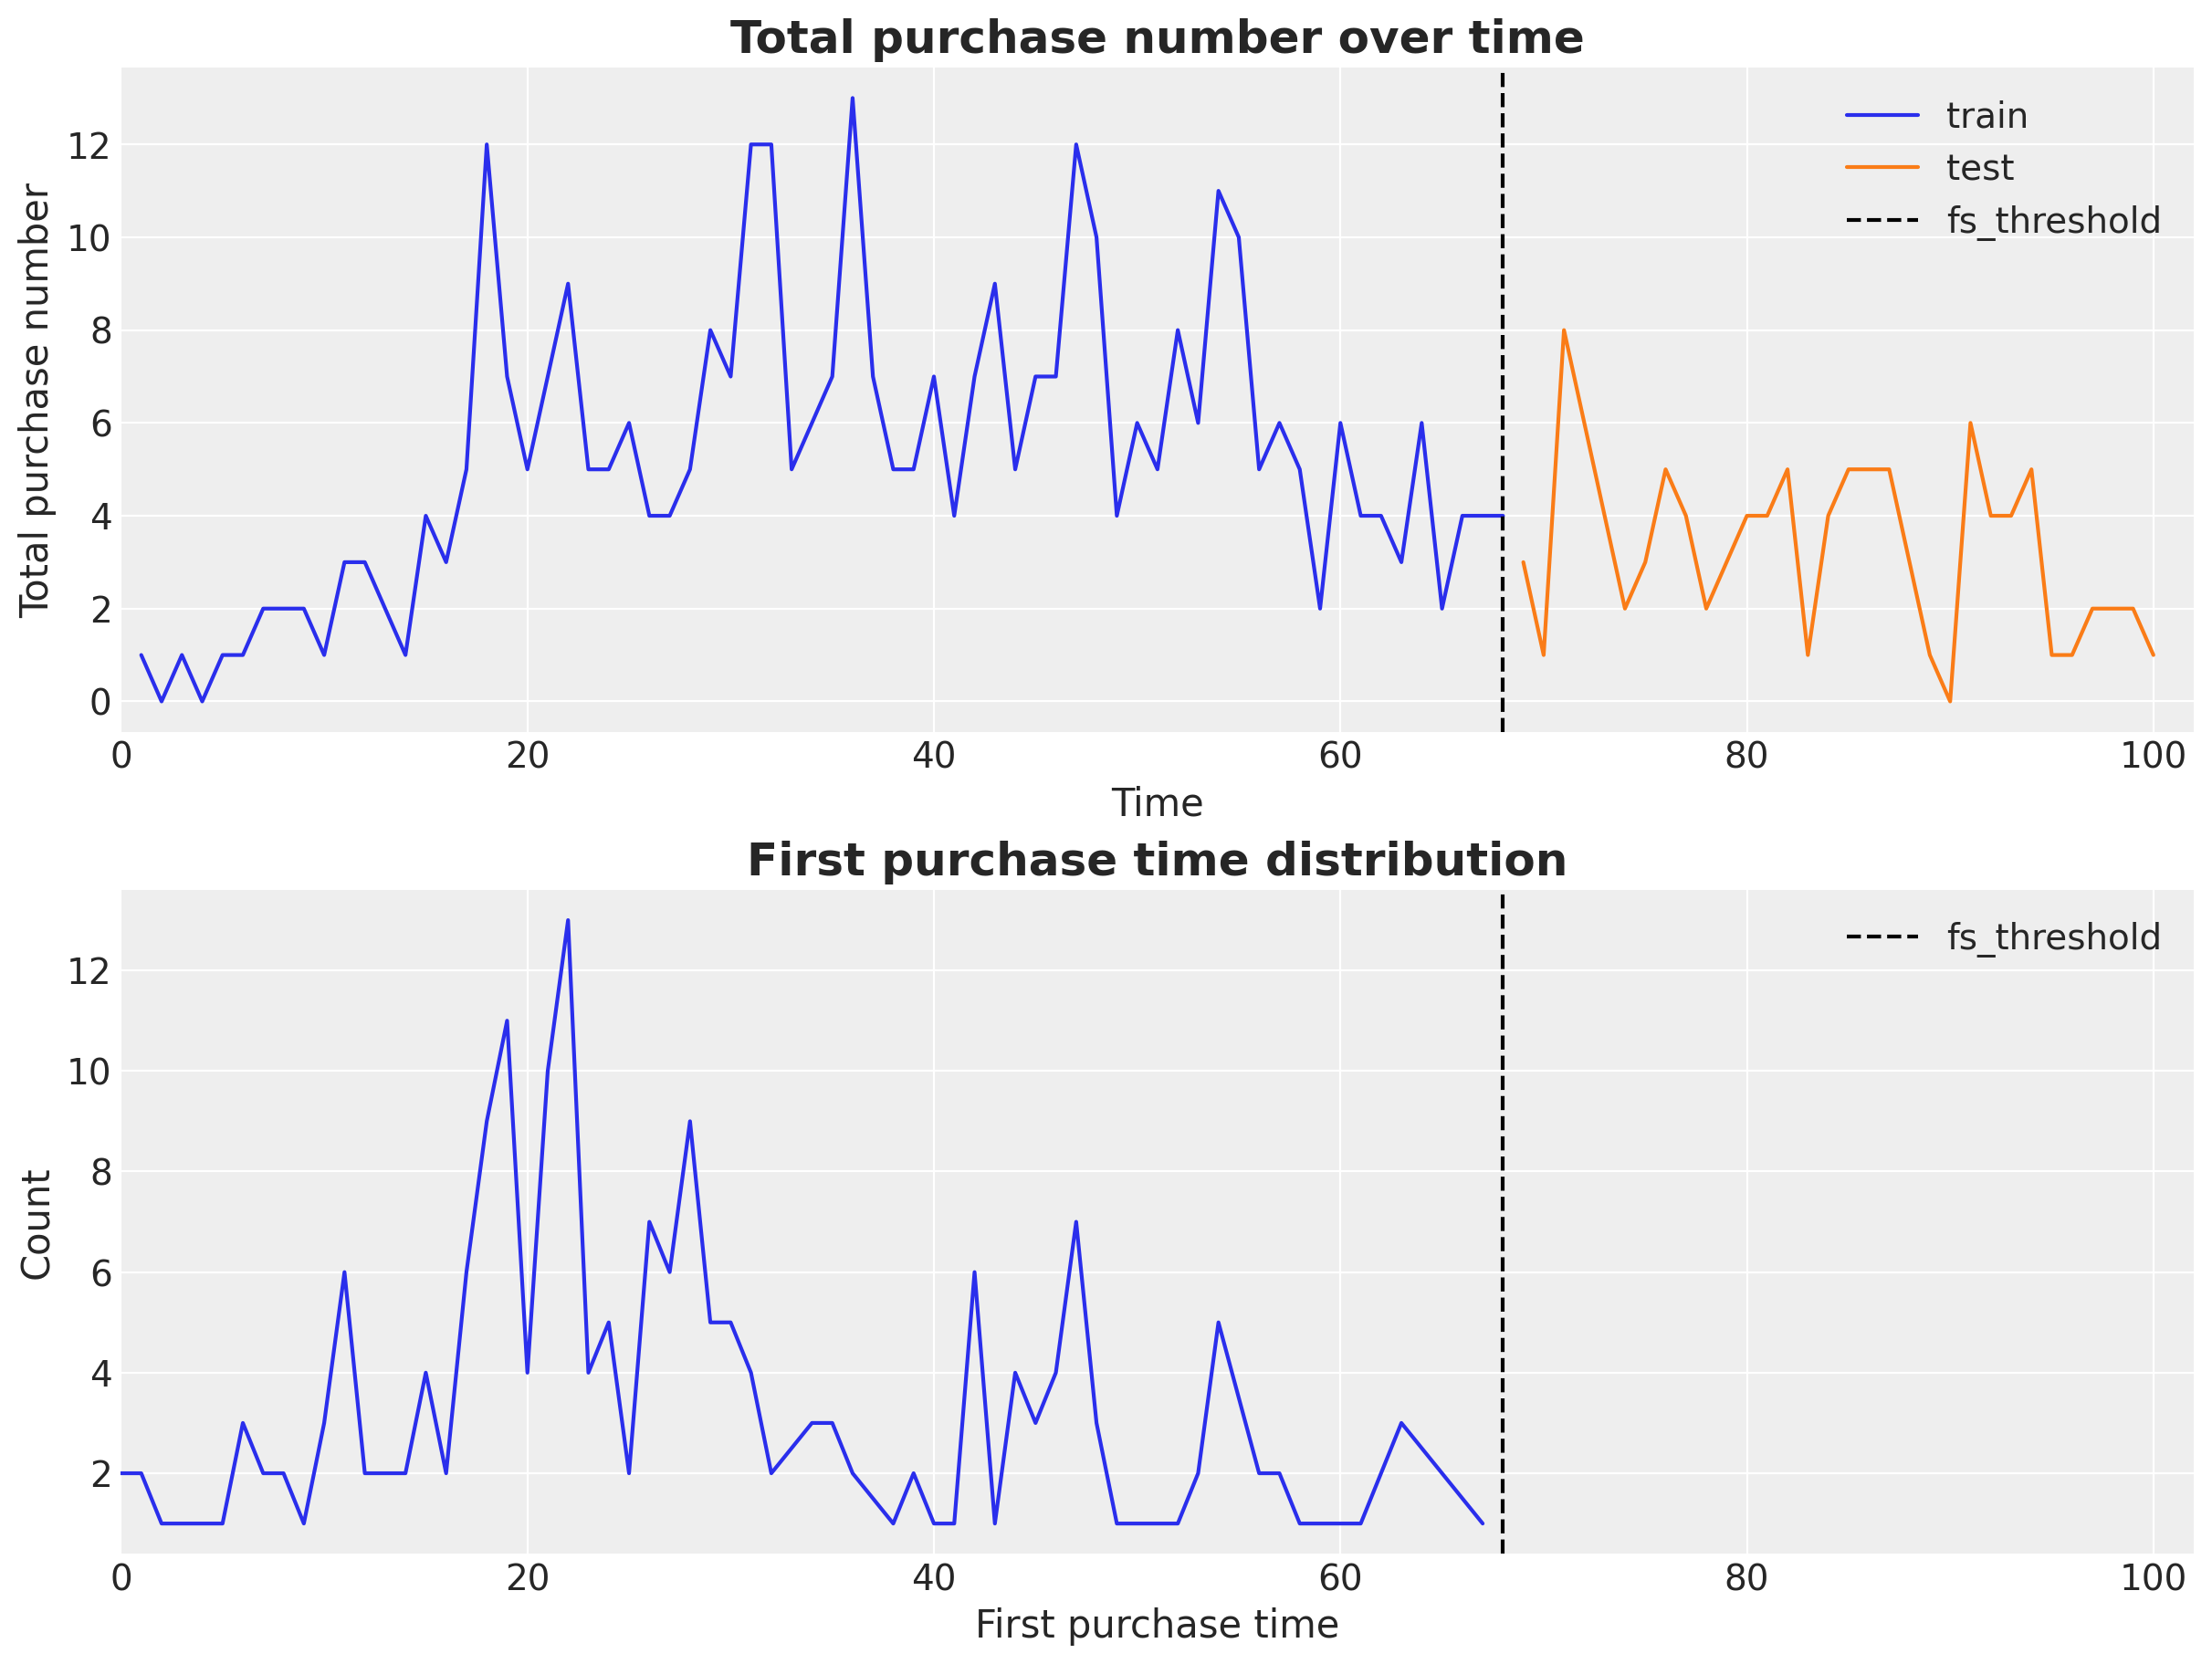

In [36]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(12, 9), sharex=False, sharey=False, layout="constrained"
)

train_df.group_by("t").agg(pl.col("y").sum().alias("total_y")).pipe(
    lambda df: sns.lineplot(
        data=df, x="t", y="total_y", color="C0", label="train", ax=ax[0]
    )
)
test_df.group_by("t").agg(pl.col("y").sum().alias("total_y")).pipe(
    lambda df: sns.lineplot(
        data=df, x="t", y="total_y", color="C1", label="test", ax=ax[0]
    )
)
ax[0].axvline(fs_threshold, color="black", linestyle="--", label="fs_threshold")
ax[0].legend(loc="upper right")
ax[0].set(xlabel="Time", ylabel="Total purchase number", xlim=(0, 102))
ax[0].set_title("Total purchase number over time", fontsize=18, fontweight="bold")

train_df.select(pl.col("id"), pl.col("fs")).unique(subset=["id", "fs"]).group_by(
    "fs"
).len().pipe(lambda df: sns.lineplot(data=df, x="fs", y="len", color="C0", ax=ax[1]))
ax[1].axvline(fs_threshold, color="black", linestyle="--", label="fs_threshold")
ax[1].legend(loc="upper right")
ax[1].set(xlabel="First purchase time", ylabel="Count", xlim=(0, 102))
ax[1].set_title("First purchase time distribution", fontsize=18, fontweight="bold");

## Model

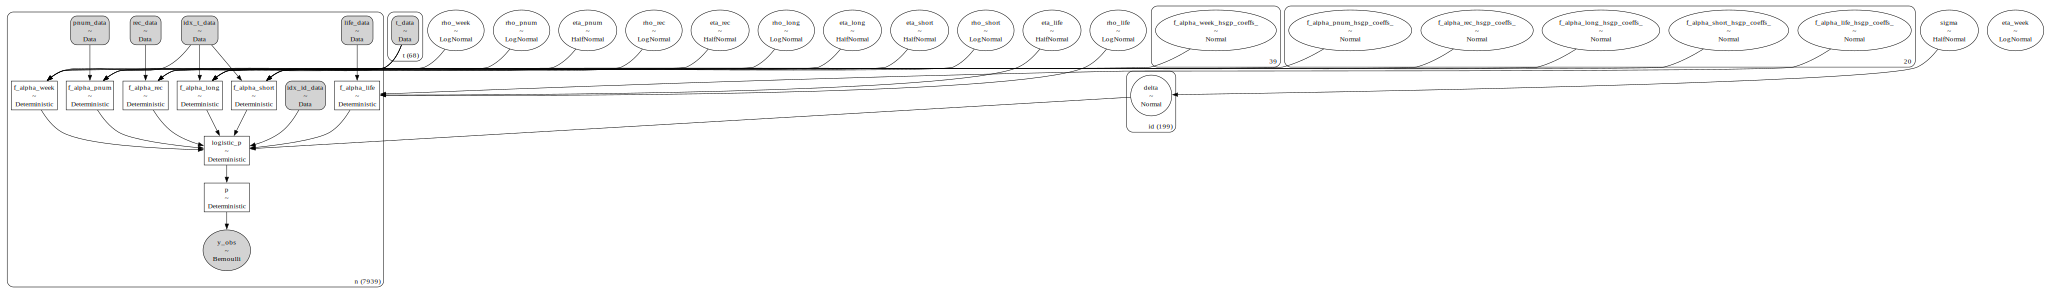

In [41]:
eps = np.finfo(float).eps

coords = {"id": id_train}

with pm.Model(coords=coords) as model:
    # --- Data Containers ---

    t_train_max = t_train.max()

    model.add_coord(name="n", values=range(n_train))
    model.add_coord(name="t", values=t_train)

    idx_id_data = pm.Data(name="idx_id_data", value=idx_id_train, dims="n")

    t_data = pm.Data(name="t_data", value=t_train, dims="t")
    idx_t_data = pm.Data(name="idx_t_data", value=idx_t_train, dims="n")

    rec_data = pm.Data(name="rec_data", value=rec_train, dims="n")
    life_data = pm.Data(name="life_data", value=life_train, dims="n")
    pnum_data = pm.Data(name="pnum_data", value=pnum_train, dims="n")

    # --- Priors ---

    ## Weekly seasonality
    eta_week = pm.LogNormal(name="eta_week", mu=0, sigma=3)
    rho_week = pm.LogNormal(name="rho_week", mu=0, sigma=2)
    cov_week = pm.gp.cov.Periodic(input_dim=1, period=7, ls=rho_week)
    gp_alpha_week = pm.gp.HSGPPeriodic(m=20, scale=1, cov_func=cov_week)
    f_alpha_week = gp_alpha_week.prior(
        name="f_alpha_week", X=t_data[idx_t_data][:, None], dims="n"
    )

    ## Long term trend
    eta_long = pm.HalfNormal(name="eta_long", sigma=5)
    rho_long = pm.LogNormal(name="rho_long", mu=0, sigma=2)
    cov_long = eta_long**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=rho_long)
    gp_alpha_long = pm.gp.HSGP(m=[20], L=[120], cov_func=cov_long)
    f_alpha_long = gp_alpha_long.prior(
        name="f_alpha_long", X=t_data[idx_t_data][:, None], dims="n"
    )

    ## Short term trend
    eta_short = pm.HalfNormal(name="eta_short", sigma=5)
    rho_short = pm.LogNormal(name="rho_short", mu=0, sigma=2)
    cov_short = eta_short**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=rho_short)
    gp_alpha_short = pm.gp.HSGP(m=[20], L=[120], cov_func=cov_short)
    f_alpha_short = gp_alpha_short.prior(
        name="f_alpha_short", X=t_data[idx_t_data][:, None], dims="n"
    )

    ## Lifetime effect
    eta_life = pm.HalfNormal(name="eta_life", sigma=5)
    rho_life = pm.LogNormal(name="rho_life", mu=0, sigma=2)
    cov_life = eta_life**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=rho_life)
    gp_alpha_life = pm.gp.HSGP(m=[20], L=[120], cov_func=cov_life)
    f_alpha_life = gp_alpha_life.prior(
        name="f_alpha_life", X=life_data[:, None], dims="n"
    )

    ## Recency effect
    eta_rec = pm.HalfNormal(name="eta_rec", sigma=5)
    rho_rec = pm.LogNormal(name="rho_rec", mu=0, sigma=2)
    cov_rec = eta_rec**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=rho_rec)
    gp_alpha_rec = pm.gp.HSGP(m=[20], L=[120], cov_func=cov_rec)
    f_alpha_rec = gp_alpha_rec.prior(name="f_alpha_rec", X=rec_data[:, None], dims="n")

    ## Purchase number effect
    eta_pnum = pm.HalfNormal(name="eta_pnum", sigma=5)
    rho_pnum = pm.LogNormal(name="rho_pnum", mu=0, sigma=2)
    cov_pnum = eta_pnum**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=rho_pnum)
    gp_alpha_pnum = pm.gp.HSGP(m=[20], L=[120], cov_func=cov_pnum)
    f_alpha_pnum = gp_alpha_pnum.prior(
        name="f_alpha_pnum", X=pnum_data[:, None], dims="n"
    )

    sigma = pm.HalfNormal(name="sigma", sigma=3)

    delta = pm.Normal(name="delta", mu=0, sigma=sigma, dims="id")

    # --- Parametrization

    logit_p = pm.Deterministic(
        name="logistic_p",
        var=(
            f_alpha_week
            + f_alpha_long
            + f_alpha_short
            + f_alpha_life
            + f_alpha_rec
            + f_alpha_pnum
            + delta[idx_id_data]
        ),
        dims="n",
    )
    p = pm.Deterministic(name="p", var=pm.math.invlogit(logit_p), dims="n")
    # We add a small epsilon to avoid numerical issues.
    p = pt.switch(pt.eq(p, 0), eps, p)
    p = pt.switch(pt.eq(p, 1), 1 - eps, p)

    # --- Likelihood ---
    pm.Bernoulli(name="y_obs", p=p, observed=y_train, dims="n")


pm.model_to_graphviz(model)

In [42]:
with model:
    prior_predictive = pm.sample_prior_predictive(samples=20, random_seed=rng)

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.12/site-packages/pytensor/tensor/rewriting/elemwise.py:702: UserWarning: Optimization Warning: The Op ive does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
Sampling: [delta, eta_life, eta_long, eta_pnum, eta_rec, eta_short, eta_week, f_alpha_life_hsgp_coeffs_, f_alpha_long_hsgp_coeffs_, f_alpha_pnum_hsgp_coeffs_, f_alpha_rec_hsgp_coeffs_, f_alpha_short_hsgp_coeffs_, f_alpha_week_hsgp_coeffs_, rho_life, rho_long, rho_pnum, rho_rec, rho_short, rho_week, sigma, y_obs]


In [43]:
with model:
    idata = pm.sample(
        target_accept=0.95,
        draws=1_000,
        chains=4,
        nuts_sampler="numpyro",
        random_seed=rng,
    )

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.12/site-packages/pytensor/tensor/rewriting/elemwise.py:702: UserWarning: Optimization Warning: The Op ive does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.12/site-packages/pytensor/tensor/rewriting/elemwise.py:702: UserWarning: Optimization Warning: The Op ive does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.12/site-packages/pytensor/tensor/rewriting/elemwise.py:702: UserWarning: Optimization Warning: The Op ive does not provide a C implementation. As well as being potentially slow, this also disables loop fusion.
  warn(
/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.12/site-packages/p

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

There were 987 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [44]:
idata.sample_stats.diverging.sum().item()

987